<a href="https://colab.research.google.com/github/aju22/Ageing-Sign-Detection/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#       **Ageing Signs Detection : A Deep Learning Solution**


![Facial Recognition](https://www.networkcomputing.com/sites/default/files/styles/article_-_feature/public/facial-recognition-man-5946820_640.jpg?itok=BIH97eYM)

#**Description**

## **Ageing Signs Detection Project** 

This project combines the possibilities of a Deep Learning model, specifically [EfficientDet](https://ai.googleblog.com/2020/04/efficientdet-towards-scalable-and.html) and Advanced Computer Vision to recognise and localise Ageing factors on a person's potrait image.

![](https://lh3.googleusercontent.com/proxy/wsjlVo4CglG7qUGz0HvlVyBFhVkoPyAPqXlEHAwbfLhXq282JrApUWgp1nYivu6iDIDtQT-EGH1iAHaQWDLMsv6AXjKuFLF9bMa7sc5tXTHyY0j7g3TjwqkaIHrzRwWFZg)

This project involved:


*   Heavy use of [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).
*   Pre-Trained EfficientDet model from [TensorFlow Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).
*   Google Colab GPU to train on our custom DataSet.



#***Mount Your Google Drive***

*  Make sure to have a folder named "**object_detection**" in your Google Drive containing the *saved_model*, *test_images* and the *labelmap*, shared by the team.

*  You can add your own **custom images** to test the model, inside the *test_images* folder(**.jpg format**). 


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Setup

### Install Dependancies

In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

In [ ]:
!pip install tensorflow-object-detection-api

In [ ]:
!pip install pycocotools

### Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## *Apply Patches*

In [2]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Loading Label Map

In [3]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/drive/MyDrive/object_detection/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Loading Test Images

In [4]:
import pathlib
# If you want to test the code with your images, just add images to the test_images folder.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/drive/MyDrive/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.*")))
TEST_IMAGE_PATHS

[PosixPath('/content/drive/MyDrive/object_detection/test_images/0_GettyImages-1162756549.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/1571de7e2c9161c3c33c0f290e73ebfe_XL.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/Melasma_1024x1024.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/dark-spots.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/gettyimages-155396133-612x612.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/gettyimages-160611506-612x612.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/gettyimages-548308223-612x612.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/gettyimages-548308279-612x612.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/gettyimages-643950372-612x612.jpg'),
 PosixPath('/content/drive/MyDrive/object_detection/test_images/gettyimages-735894989-612x612.jpg'),
 PosixPath('/content

# Detection

Loading our pre-trained *EfficientDet* model for Detecting Ageing factors.

In [5]:
detection_model = tf.saved_model.load('/content/drive/MyDrive/object_detection/saved_model')

In [7]:
detection_model.signatures['serving_default'].output_dtypes

{'detection_anchor_indices': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'raw_detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32}

Adding a wrapper function to call the model, and cleanup the outputs:

In [9]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [26]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  path = str(image_path)
  path = path.replace('test_images', 'predicted_images')
  im = Image.fromarray(image_np)
  display(im)
  im.save(path)

Run it on each test image and show the results:

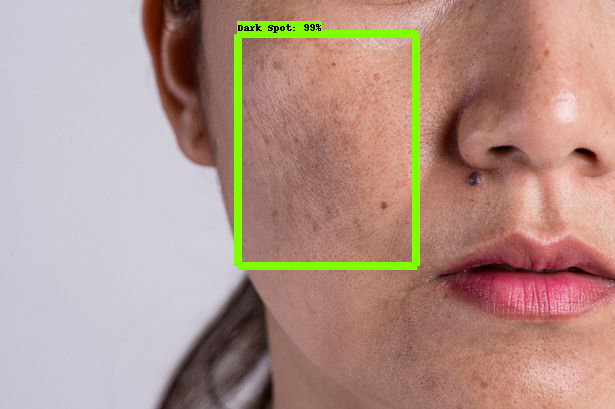

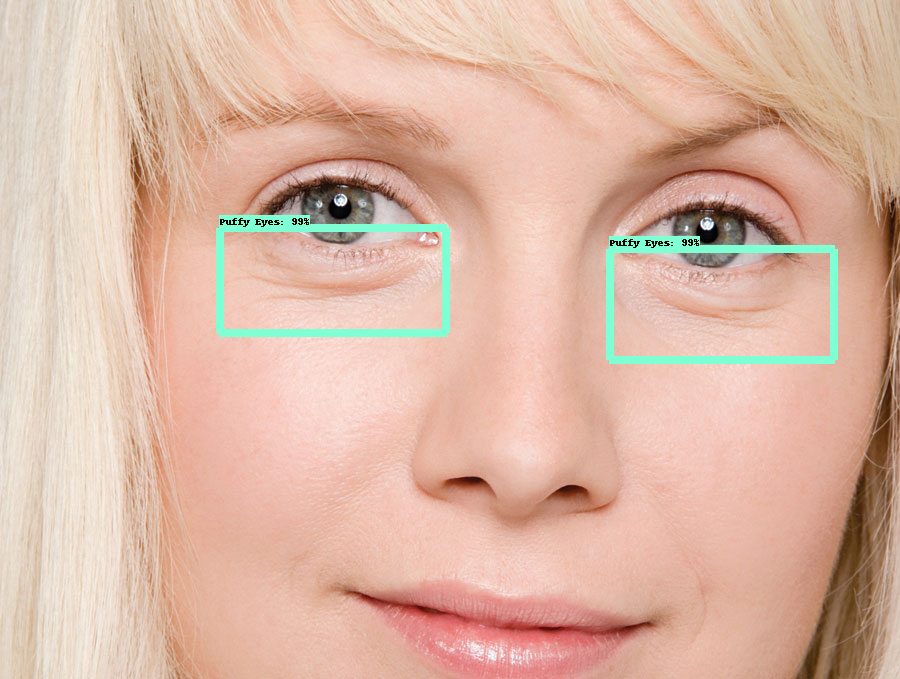

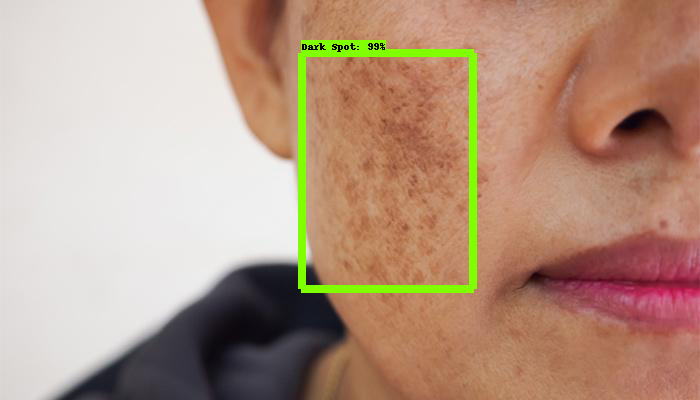

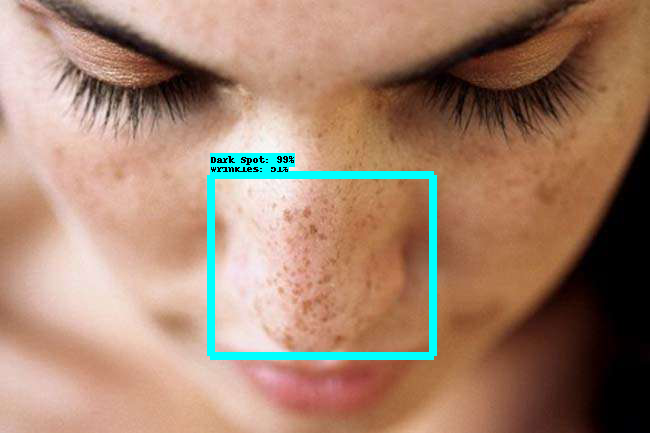

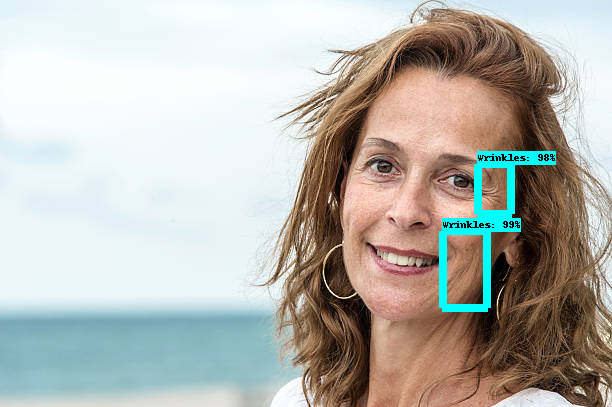

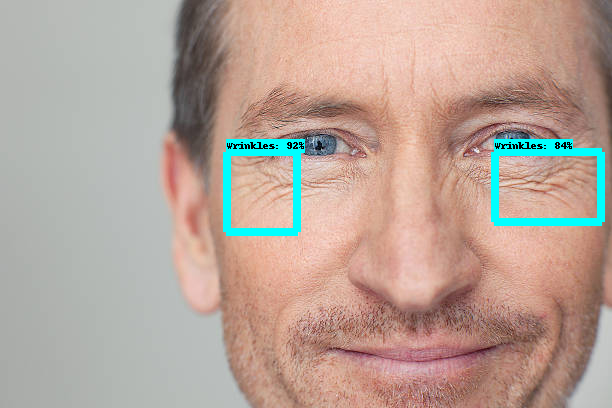

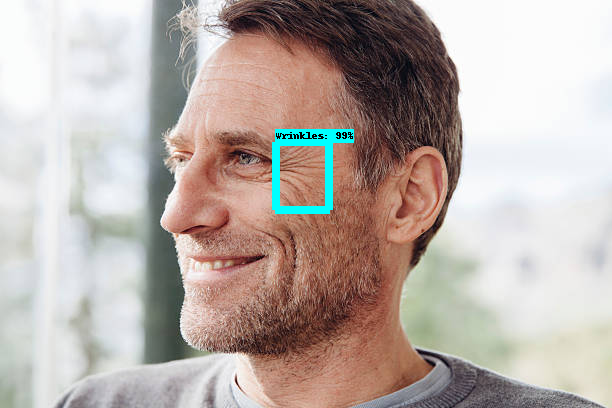

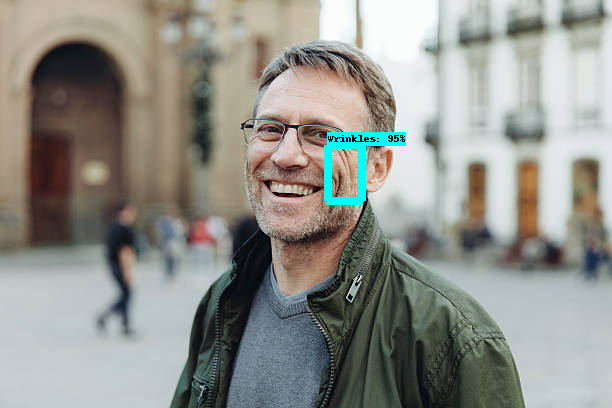

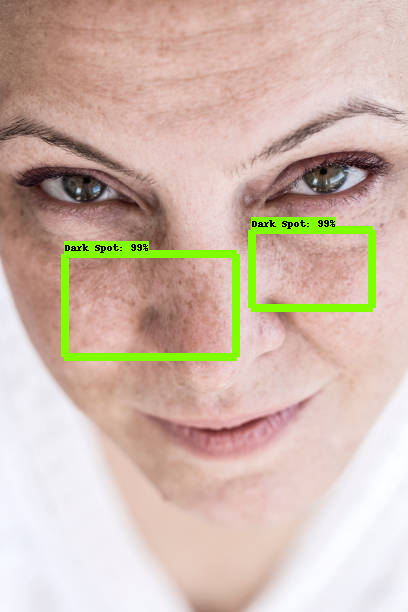

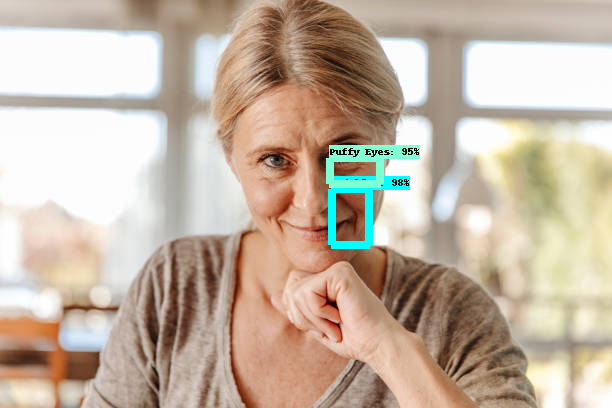

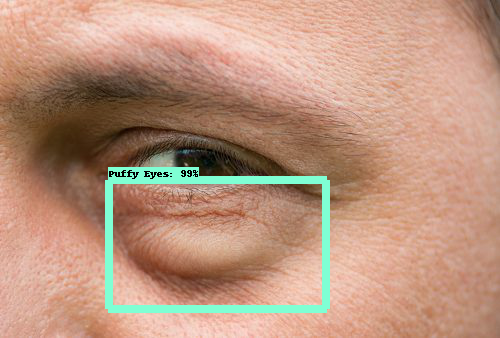

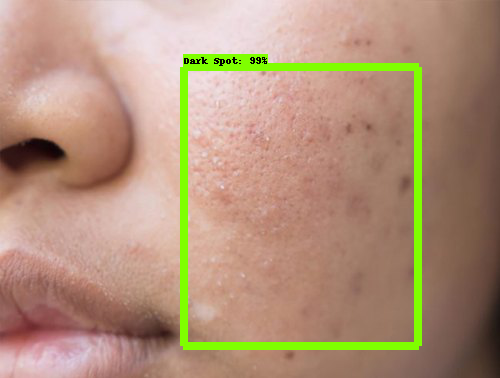

In [28]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

#**References**


1. [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)


2.  [A thorough breakdown of Efficientdet for Object Detection](https://towardsdatascience.com/a-thorough-breakdown-of-efficientdet-for-object-detection-dc6a15788b73)


3.   [TensorFlow Tutorials-Object_Detection](https://www.tensorflow.org/hub/tutorials/object_detection)


4.   [Tensorflow Object Detection with Tensorflow 2: Creating a Custom Model](https://www.youtube.com/watch?v=cvyDYdI2nEI)    